In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
grid.py — grid driver for ECLIPSE-Xλ

This driver builds the channel mesh (MRT) and runs a small grid of scenarios.

What this script does:
  • Load the channel grid ("MRT") either from file or directly from your own
    per-channel arrays (centers and widths).
  • Warm up PHOENIX cache for the temperatures we need.
  • Build grey/Planck limb-darkening coefficients integrated over the real
    channel windows.
  • Configure instrument pre-convolution:
      - constant R, or
      - variable R(λ) AUTOMATICALLY derived from your channel widths.
  • Run scenarios (unspotted, spots, faculae, both) and write out D(λ).

All knobs are at the top and documented in ENGLISH (as requested).
"""

from __future__ import annotations
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# ----- engine -----
from main import (
    MainProgram,
    preflight_occultation_check,
    _ratio_channel_integrate_seds,
    _smooth_contrast_curve,
)

# ----- PHOENIX / hybrid -----
from phoenix_sed import (
    warm_phoenix_cache,
    phoenix_flux_interp_um,
    phoenix_continuum_hybrid_global_tamed,
    T_MIN_PHX, T_MAX_PHX,
)

# ============================================================================
# 0) MASTER KNOBS — CONFIGURE HERE (all in ENGLISH)
# ============================================================================

# --- General / target ---
TARGET = "LHS1140b"

# --- Plot controls ---
PLOTS_ON = False            # summary plots after runs
PLOT_PREVIEW_SED = False    # not used here, placeholder

# --- Planck-trend knobs (pass-through to engine) ---
# Enable/disable Planck-like trend substitution and set the constant-R low-pass (in log-λ)
# used by the trend model (higher R => gentler trend). Keep defaults to avoid changing behavior.
TREND_FIX_ENABLE = True
TREND_R_LP       = 50.0

# --- Quick sanity preview (r(λ) toy calc) ---
SANITY_QUICK_ON = False
SANITY_Q_R_GAMMA = 0.22

# --- Channel window (apodization) ---
APODIZE_TUKEY = True
TUKEY_ALPHA = 0.80  # only used if APODIZE_TUKEY=True

# --- Average amplitude scalers (global) ---
SPOT_BOOST   = 1.0
FACULA_BOOST = 1.0

# --- Channel mesh (MRT) source ---
# Choose how your channel grid is provided:
#   "file"   => read from MRT_PATH (columns: center_um, width_um, ...)
#   "manual" => use arrays you provide below (USER_LAMBDA_UM / USER_WIDTH_UM)
MRT_INPUT_MODE = "file"      # "file" or "manual"
MRT_PATH = "apjlad5afat2_mrt.txt"  # used when MRT_INPUT_MODE="file"
USE_ORDER = None             # None, 1, 2 (if your MRT has order column)

# --- Channel grid (manual mode) ---
# Option A: fill arrays below directly (µm). Widths are FWHM-ish integration widths.
USER_LAMBDA_UM = None  # e.g., np.array([0.60, 0.605, ...], float)
USER_WIDTH_UM  = None  # e.g., np.array([0.006, 0.006, ...], float)
# Option B: point to a CSV with columns: lambda_um (or lambda_nm), and either
#           width_um, width_nm, or R (if R is provided, width will be λ/R).
MANUAL_CHANNELS_CSV = None

# --- Minimum per-channel resolving power floor from width (sanity clamp) ---
R_MIN_CHAN_FLOOR = 300.0

# --- Instrument pre-convolution mode ---
# AUTO_R_FROM_CHANNELS=True  => use R(λ) derived automatically from channel widths
# If False, choose CONSTANT_R (or None to skip).
AUTO_R_FROM_CHANNELS = False
CONSTANT_R = 25  # e.g., 100.0 (ignored if AUTO_R_FROM_CHANNELS=True)

# Auto-R(λ) knobs (only used if AUTO_R_FROM_CHANNELS=True)
R_AUTO_BETA     = 1.0   # LSF-vs-window calibration factor (start with 1.0)
R_AUTO_SMOOTH_R = 520.0 # low-pass on R(λ) in log λ (larger => smoother)
R_AUTO_FLOOR_R  = R_MIN_CHAN_FLOOR  # ensure R(λ) never drops below this

# --- Zeeman (placeholders — OFF) ---
ZEEMAN_ENABLE = False
ZEEMAN_G_EFF = 1.0
ZEEMAN_PI_FRAC = 0.5
ZEEMAN_B_QUIET_KG = 0.0
ZEEMAN_B_SPOT_KG  = 0.0
ZEEMAN_B_FACULA_KG= 0.0

# --- Output files ---
OUT_TXT = f"simulation_results_{TARGET}.txt"
EXTRA_OUTS = [
    "stack_covariances.npz", "stack_covariances_tls.npz",
    f"interpolated_results_{TARGET}_both.txt"
]
for f in [OUT_TXT, *EXTRA_OUTS]:
    try:
        if os.path.exists(f):
            os.remove(f)
            print(f"[CLEAN] removed '{f}'")
    except Exception as e:
        print(f"[CLEAN] could not remove '{f}': {e}")

# --- PHOENIX / hybrid base preset ---
_BASE = dict(
    SED_MODE_PHOT   = "phoenix",
    SED_MODE_ACTIVE = "phoenix",

    # Hybrid (if you switch to *_hybrid* modes)
    R_CONTINUUM = 20,   # we'll set a safe fallback below
    HYB_Q = 0.990,
    HYB_BINS_PER_R = 12.0,
    SC_RWIN_QUANT = 100.0,
    SC_RWIN_CLOSE = 220.0,
    SC_POST_GAUSS = 0.05,
    HYB_ALPHA_MIX = 0.50,
    HYB_BETA_ENV  = 1.00,
    HYB_CAP_ENV   = None,
    HYB_R_POST    = None,

    # Ripple (lines) — amplitude-only tamer
    RIPPLE_ALPHA_PHOT = 1.0,
    RIPPLE_ALPHA_SPOT = 1.0,
    RIPPLE_ALPHA_FAC  = 1.0,

    # r(λ) smoothing (global)
    CONTRAST_ENABLE    = True,
    CONTRAST_LOWPASS_R = 90.0,
    CONTRAST_HF_GAMMA  = 0.35,
    CONTRAST_FFT       = False,

    # Floors (off)
    RATIO_FLOOR_SPOT   = None,
    RATIO_FLOOR_FACULA = None,

    SAME_HYBRID_FOR_ALL = True,
)
GENTLE_LINES_NIR = _BASE.copy()
ACTIVE_PRESET = GENTLE_LINES_NIR

# --- Star / geometry ---
intensidadeMaxima = 1000
min_pixels, max_pixels, pixels_per_rp = 100, 2000, 55
raioStar, massStar, tempStar = 0.2159, 0.1844, 3096.0
raioPlanetaRj, periodo, anguloInclinacao = 0.1543, 24.73723, 89.86
semiEixoUA, ecc, anom = 0.0946, 0.0, 0.0

# --- Grey LDCs (integrated per channel) ---
USE_GREY_LDC = True
GREY_MU_TAU_ALPHA = 1.0
GREY_Q_EDD        = 2.0/3.0
GREY_POST_SMOOTH_R = False  # False or e.g. 320.0

# ============================================================================
# 1) Pull preset fields
# ============================================================================
def _pull(k): return ACTIVE_PRESET[k]
SED_MODE_PHOT   = _pull("SED_MODE_PHOT")
SED_MODE_ACTIVE = _pull("SED_MODE_ACTIVE")
R_CONTINUUM     = _pull("R_CONTINUUM")
HYB_Q           = _pull("HYB_Q")
HYB_BINS_PER_R  = _pull("HYB_BINS_PER_R")
SC_RWIN_QUANT   = _pull("SC_RWIN_QUANT")
SC_RWIN_CLOSE   = _pull("SC_RWIN_CLOSE")
SC_POST_GAUSS   = _pull("SC_POST_GAUSS")
HYB_ALPHA_MIX   = _pull("HYB_ALPHA_MIX")
HYB_BETA_ENV    = _pull("HYB_BETA_ENV")
HYB_CAP_ENV     = _pull("HYB_CAP_ENV")
HYB_R_POST      = _pull("HYB_R_POST")
HYB_RIPPLE_ALPHA_PHOT = _pull("RIPPLE_ALPHA_PHOT")
HYB_RIPPLE_ALPHA_SPOT = _pull("RIPPLE_ALPHA_SPOT")
HYB_RIPPLE_ALPHA_FAC  = _pull("RIPPLE_ALPHA_FAC")
CONTRAST_ENABLE      = _pull("CONTRAST_ENABLE")
CONTRAST_LOWPASS_R   = _pull("CONTRAST_LOWPASS_R")
CONTRAST_HF_GAMMA    = _pull("CONTRAST_HF_GAMMA")
CONTRAST_FFT         = _pull("CONTRAST_FFT")
RATIO_FLOOR_SPOT     = _pull("RATIO_FLOOR_SPOT")
RATIO_FLOOR_FACULA   = _pull("RATIO_FLOOR_FACULA")
SAME_HYBRID_FOR_ALL  = _pull("SAME_HYBRID_FOR_ALL")

R_CONTINUUM_FALLBACK = 50.0 if (R_CONTINUUM is None) else float(R_CONTINUUM)
VSINI_KMS, ROT_LD_EPS, MACRO_KMS = 1.5, 0.7, 1.0

# ============================================================================
# 2) Helpers (Planck LDCs + small utils)
# ============================================================================
_h = 6.62607015e-34; _c = 2.99792458e8; _k = 1.380649e-23
_EPS = 1e-15

def _planck_lambda_um(lam_um: np.ndarray, T: float) -> np.ndarray:
    lam_m = np.asarray(lam_um, float) * 1e-6
    x = (_h * _c) / (_k * T) / np.clip(lam_m, 1e-30, None)
    ex = np.exp(np.clip(x, 1e-9, 700.0)) - 1.0
    return (1.0 / np.clip(lam_m, 1e-30, None)**5) / np.clip(ex, 1e-30, None)

def _tukey_window_segment(lam, lo, hi, alpha=0.6):
    L = hi - lo
    if not np.isfinite(L) or L <= 0: return np.zeros_like(lam)
    u = (lam - lo) / L
    w = np.zeros_like(lam)
    a = float(np.clip(alpha, 0.0, 1.0))
    left  = (u >= 0) & (u < a/2)
    right = (u <= 1) & (u > 1-a/2)
    mid   = (u >= a/2) & (u <= 1-a/2)
    w[left ] = 0.5 * (1 + np.cos(np.pi*(2*u[left ]/a - 1)))
    w[right] = 0.5 * (1 + np.cos(np.pi*(2*u[right]/a - 2/a + 1)))
    w[mid  ] = 1.0
    w[(u < 0) | (u > 1)] = 0.0
    s = float(np.trapz(w, lam)) or 1.0
    return w / s

def _lp_constR_loglambda(lam_um, y, R=300.0):
    lam = np.asarray(lam_um, float)
    z = np.log(np.clip(lam, 1e-12, None))
    yg = np.asarray(y, float)
    dz = 1.0 / (max(float(R), 1e-6) * 12.0)
    z_grid = np.arange(z.min(), z.max() + 1e-12, dz)
    y_grid = np.interp(z_grid, z, yg)
    sigma = 1.0 / (2.355 * max(float(R), 1e-6))
    half = int(max(3, np.ceil(6.0 * sigma / dz)))
    k = np.arange(-half, half+1) * dz
    ker = np.exp(-0.5 * (k / max(sigma, 1e-15))**2)
    ker /= (float(ker.sum()) or 1.0)
    yg_conv = np.convolve(np.pad(y_grid, (half, half), mode="edge"),
                          ker, mode="same")[half:-half]
    return np.interp(z, z_grid, yg_conv)

def ldc_grey_planck(
    *, lambdaEff_um, dx_low_um, dx_high_um, Teff,
    mu_tau_alpha=1.0, q_edd=2.0/3.0,
    channel_window_kind="tukey", channel_tukey_alpha=0.6,
    throughput_pair=None,
    nmu=51, post_smooth_R=320.0
):
    lam_c = np.asarray(lambdaEff_um, float)
    dlo   = np.asarray(dx_low_um, float)
    dhi   = np.asarray(dx_high_um, float)
    n_ch  = lam_c.size
    mu = np.linspace(0.02, 1.0, int(max(9, nmu)))

    c1 = np.zeros(n_ch); c2 = np.zeros(n_ch)
    c3 = np.zeros(n_ch); c4 = np.zeros(n_ch)
    X = np.column_stack([1 - mu**0.5, 1 - mu, 1 - mu**1.5, 1 - mu**2])

    for i in range(n_ch):
        lo = float(lam_c[i] + dlo[i]); hi = float(lam_c[i] + dhi[i])
        if not (np.isfinite(lo) and np.isfinite(hi) and hi > lo): continue

        nlam = max(121, int(6 * (hi - lo) / (lam_c[i]/max(lam_c[i], _EPS)/100.0)))
        lam = np.linspace(lo, hi, nlam)

        if channel_window_kind.lower().startswith("tukey"):
            W = _tukey_window_segment(lam, lo, hi, alpha=channel_tukey_alpha)
        else:
            W = np.where((lam >= lo) & (lam <= hi), 1.0, 0.0)
            W /= (float(np.trapz(W, lam)) or 1.0)

        if throughput_pair is not None:
            lam_thr, thr = throughput_pair
            W = W * np.interp(lam, lam_thr, thr, left=0.0, right=0.0)
            W /= (float(np.trapz(W, lam)) or 1.0)

        I_mu = np.empty_like(mu)
        for j, muj in enumerate(mu):
            tau = float(mu_tau_alpha) * float(muj)
            T_tau = float(Teff) * np.power(0.75 * (tau + q_edd), 0.25)
            Bl = _planck_lambda_um(lam, T_tau)
            I_mu[j] = float(np.trapz(Bl * W, lam))

        S = I_mu / max(I_mu[-1], _EPS)
        y = 1.0 - S
        coef, *_ = np.linalg.lstsq(X, y, rcond=None)
        c1[i], c2[i], c3[i], c4[i] = coef

    if post_smooth_R is not None and post_smooth_R:
        c1 = _lp_constR_loglambda(lam_c, c1, R=float(post_smooth_R))
        c2 = _lp_constR_loglambda(lam_c, c2, R=float(post_smooth_R))
        c3 = _lp_constR_loglambda(lam_c, c3, R=float(post_smooth_R))
        c4 = _lp_constR_loglambda(lam_c, c4, R=float(post_smooth_R))
    return c1, c2, c3, c4

# ============================================================================
# 3) Build MRT (from file or manual)
# ============================================================================
def _load_niriss_mrt(path: str):
    CWave_um, Width_um = [], []
    Depth_b_ppm, eDepth_b_ppm = [], []
    Order = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if (not s) or s.startswith(("#",";")): continue
            if s.lower().startswith(("title","table","note","column")) or s.startswith("---"):
                continue
            s = s.replace(",", " ")
            vals=[]
            for tok in s.split():
                try: vals.append(float(tok))
                except: pass
            if len(vals) < 2:
                continue
            # expecting: center_um, width_um, optional extras (depth, error, order...)
            cw = vals[0]
            width = vals[1]
            ordv = int(round(vals[6])) if (len(vals) >= 7) else 0
            edb = vals[3] if (len(vals) >= 4) else np.nan
            db  = vals[2] if (len(vals) >= 3) else np.nan
            CWave_um.append(cw); Width_um.append(width)
            Depth_b_ppm.append(db); eDepth_b_ppm.append(edb)
            Order.append(ordv)
    if len(CWave_um) == 0:
        raise ValueError(f"No numeric rows found in '{path}'.")
    CWave_um = np.asarray(CWave_um, float); Width_um = np.asarray(Width_um, float)
    Depth_b_ppm = np.asarray(Depth_b_ppm, float); eDepth_b_ppm = np.asarray(eDepth_b_ppm, float)
    Order = np.asarray(Order, int)
    idx = np.argsort(CWave_um)
    return (CWave_um[idx], Width_um[idx], Depth_b_ppm[idx], eDepth_b_ppm[idx], Order[idx])

def _load_manual_channels():
    if MANUAL_CHANNELS_CSV and os.path.exists(MANUAL_CHANNELS_CSV):
        df = pd.read_csv(MANUAL_CHANNELS_CSV)
        lam = None; width = None
        if "lambda_um" in df.columns:
            lam = df["lambda_um"].astype(float).to_numpy()
        elif "lambda_nm" in df.columns:
            lam = df["lambda_nm"].astype(float).to_numpy() / 1000.0
        if "width_um" in df.columns:
            width = df["width_um"].astype(float).to_numpy()
        elif "width_nm" in df.columns:
            width = df["width_nm"].astype(float).to_numpy() / 1000.0
        elif "R" in df.columns:
            Rv = df["R"].astype(float).to_numpy()
            width = (lam / np.maximum(Rv, 1e-9))
        if lam is None:
            raise ValueError("CSV must have 'lambda_um' or 'lambda_nm'.")
        if width is None:
            raise ValueError("CSV must have 'width_um'/'width_nm' or 'R'.")
        return np.asarray(lam, float), np.asarray(width, float)
    # arrays in-code
    if USER_LAMBDA_UM is None:
        raise FileNotFoundError("Manual mode: please set USER_LAMBDA_UM (and USER_WIDTH_UM or CSV).")
    lam = np.asarray(USER_LAMBDA_UM, float)
    if USER_WIDTH_UM is not None:
        width = np.asarray(USER_WIDTH_UM, float)
    else:
        # derive widths from midpoints (safe fallback) and floor by R_MIN_CHAN_FLOOR
        lam_sort = np.sort(lam)
        edges = np.zeros(lam_sort.size + 1, float)
        edges[1:-1] = 0.5 * (lam_sort[:-1] + lam_sort[1:])
        edges[0]  = lam_sort[0]  - 0.5*(lam_sort[1]  - lam_sort[0])
        edges[-1] = lam_sort[-1] + 0.5*(lam_sort[-1] - lam_sort[-2])
        width_sort = np.diff(edges)
        order = np.argsort(lam)
        inv   = np.argsort(order)
        width = width_sort[inv]
        width = np.maximum(width, lam/float(R_MIN_CHAN_FLOOR))
    return lam, width

obs_depth_ppm = None; obs_edepth_ppm = None
if MRT_INPUT_MODE.lower() == "file":
    if not os.path.exists(MRT_PATH):
        raise FileNotFoundError(f"'{MRT_PATH}' not found — set MRT_INPUT_MODE='manual' or fix the path.")
    lam_obs_um, width_obs_um, depth_b_ppm, edepth_b_ppm, order = _load_niriss_mrt(MRT_PATH)
    if USE_ORDER in (1, 2):
        m = (order == USE_ORDER)
        lam_obs_um, width_obs_um = lam_obs_um[m], width_obs_um[m]
        depth_b_ppm, edepth_b_ppm, order = depth_b_ppm[m], edepth_b_ppm[m], order[m]
    bad = (~np.isfinite(width_obs_um)) | (width_obs_um <= 0)
    if np.any(bad):
        print(f"[MRT] fixing {bad.sum()} channels with width<=0/NaN")
        width_obs_um = np.where(bad, lam_obs_um/R_MIN_CHAN_FLOOR, width_obs_um)
    width_obs_um = np.maximum(width_obs_um, lam_obs_um/R_MIN_CHAN_FLOOR)
    lambdaEff = lam_obs_um.copy()
    dx_low_um_use  = -0.5 * width_obs_um
    dx_high_um_use = +0.5 * width_obs_um
    obs_depth_ppm = depth_b_ppm; obs_edepth_ppm = edepth_b_ppm
    print(f"[OBS] MRT: {len(lambdaEff)} channels, {lambdaEff.min():.3f}–{lambdaEff.max():.3f} µm")
else:
    lam_um, width_um = _load_manual_channels()
    lam_um  = np.asarray(lam_um,  float)
    width_um= np.asarray(width_um,float)
    width_um = np.maximum(width_um, lam_um/float(R_MIN_CHAN_FLOOR))
    order = np.zeros_like(lam_um, int)
    lambdaEff = lam_um.copy()
    dx_low_um_use  = -0.5 * width_um
    dx_high_um_use = +0.5 * width_um
    print(f"[MANUAL] channels: {len(lambdaEff)} from {lambdaEff.min():.3f} to {lambdaEff.max():.3f} µm")

# Warm up PHOENIX
def _to_phx_grid(T): return float(int(round(np.clip(T, T_MIN_PHX, T_MAX_PHX)/100.0)*100))
def _build_T_need(temp_star: float) -> list[float]:
    delta_T, step_T = 800.0, 30.0
    T_spot_min, T_spot_max = temp_star - delta_T, temp_star - step_T
    T_fac_min,  T_fac_max  = temp_star + step_T, temp_star + delta_T
    Ts = sorted({_to_phx_grid(t) for t in [temp_star, T_spot_min, T_spot_max, T_fac_min, T_fac_max]})
    return [t for t in Ts if T_MIN_PHX <= t <= T_MAX_PHX]

T_need = _build_T_need(tempStar)
print(f"[PHX] warming cache for Teff nodes: {T_need}")
warm_phoenix_cache(lambdaEff, T_list=T_need, feh=0.0, download_missing=True)

# ============================================================================
# 4) LDCs (grey + Planck)
# ============================================================================
print("[LDC] grey + Planck (no LDTK)")
c1, c2, c3, c4 = ldc_grey_planck(
    lambdaEff_um=lambdaEff, dx_low_um=dx_low_um_use, dx_high_um=dx_high_um_use,
    Teff=float(tempStar),
    mu_tau_alpha=GREY_MU_TAU_ALPHA, q_edd=GREY_Q_EDD,
    channel_window_kind=("tukey" if APODIZE_TUKEY else "rect"),
    channel_tukey_alpha=TUKEY_ALPHA,
    throughput_pair=None,
    nmu=101, post_smooth_R=GREY_POST_SMOOTH_R
)

print(f"[CONFIG] LDCs origin = grey/Planck")

# ============================================================================
# 5) Component-specific overrides and other params
# ============================================================================
def _component_overrides(kind: str):
    if kind == "spot":
        base = dict(
            hybrid_ripple_alpha_spot = HYB_RIPPLE_ALPHA_SPOT,
            contrast_r_floor_spot = RATIO_FLOOR_SPOT,
            contrast_fft_spot = CONTRAST_FFT,
            contrast_lowpass_R_spot = CONTRAST_LOWPASS_R if CONTRAST_ENABLE else None,
            contrast_hf_gamma_spot = CONTRAST_HF_GAMMA,
        )
        if not SAME_HYBRID_FOR_ALL:
            base.update(hybrid_R_blur_spot=R_CONTINUUM_FALLBACK, hybrid_R_post_spot=HYB_R_POST)
        return base
    if kind == "facula":
        base = dict(
            hybrid_ripple_alpha_facula = HYB_RIPPLE_ALPHA_FAC,
            contrast_r_floor_facula = RATIO_FLOOR_FACULA,
            contrast_fft_facula = CONTRAST_FFT,
            contrast_lowpass_R_facula = CONTRAST_LOWPASS_R if CONTRAST_ENABLE else None,
            contrast_hf_gamma_facula = CONTRAST_HF_GAMMA,
        )
        if not SAME_HYBRID_FOR_ALL:
            base.update(hybrid_R_blur_facula=R_CONTINUUM_FALLBACK, hybrid_R_post_facula=HYB_R_POST)
        return base
    return {}

# Pre-convolution mode
if AUTO_R_FROM_CHANNELS:
    R_PRECONV = "auto"
else:
    R_PRECONV = CONSTANT_R  # None or float

print(f"[CONFIG] Using preset: {ACTIVE_PRESET}")
print(f"[CONFIG] sed_mode_phot/active = {SED_MODE_PHOT} / {SED_MODE_ACTIVE}")
print(f"[CONFIG] r-smoothing: enable={CONTRAST_ENABLE} R={CONTRAST_LOWPASS_R} γ={CONTRAST_HF_GAMMA}")
print(f"[CONFIG] pre-convolution: {'R(λ) auto from channels' if AUTO_R_FROM_CHANNELS else ('R='+str(CONSTANT_R) if CONSTANT_R else 'off')}")

other_params = {
    'num_elements': len(lambdaEff),
    'profile': "claret4",
    'c1': c1, 'c2': c2, 'c3': c3, 'c4': c4,
    'lambdaEff': lambdaEff,
    'target': TARGET,
    'intensidadeMaxima': intensidadeMaxima,
    'raioStar': raioStar, 'ecc': ecc, 'anom': anom, 'tempStar': tempStar,
    'lat_spot': np.array([+30.0]), 'long_spot': np.array([+30.0]), 'quantidade_spot': 1,
    'lat_fac':  np.array([+30.0]), 'long_fac':  np.array([-30.0]), 'quantidade_fac': 1,
    'starspots': True, 'quantidade': 1,
    'lat': np.array([+30.0, +30.0]), 'longt': np.array([-30.0, +30.0]),
    'semiEixoUA': semiEixoUA, 'massStar': massStar,
    'plot_anim': False, 'periodo': periodo, 'anguloInclinacao': anguloInclinacao,
    'raioPlanetaRj': raioPlanetaRj, 'plot_graph': False, 'plot_star': False,
    'min_pixels': min_pixels, 'max_pixels': max_pixels, 'pixels_per_rp': pixels_per_rp,

    # Channel Δλ
    'dx_low_um':  dx_low_um_use,
    'dx_high_um': dx_high_um_use,

    # Channel integration
    'R_fallback': 150.0, 'nsub_obs': 4201,
    'channel_window_kind': ("tukey" if APODIZE_TUKEY else "rect"),
    'channel_tukey_alpha': TUKEY_ALPHA,

    # Physical SEDs
    'sed_mode_phot':   SED_MODE_PHOT,
    'sed_mode_active': SED_MODE_ACTIVE,
    'R_continuum': R_CONTINUUM_FALLBACK,

    # Hybrid defaults (if using *_hybrid*)
    'hybrid_R_blur': R_CONTINUUM_FALLBACK, 'hybrid_beta_env': HYB_BETA_ENV,
    'hybrid_cap_env': HYB_CAP_ENV, 'hybrid_alpha_mix': HYB_ALPHA_MIX,
    'hybrid_R_post': HYB_R_POST, 'hybrid_q': HYB_Q,
    'hybrid_bins_per_R': HYB_BINS_PER_R,
    'hybrid_Rwin_quant': SC_RWIN_QUANT, 'hybrid_Rwin_close': SC_RWIN_CLOSE,
    'hybrid_post_gauss_um': SC_POST_GAUSS,
    'hybrid_ripple_alpha': HYB_RIPPLE_ALPHA_PHOT,

    # Instrument pre-convolution (constant or AUTO)
    'R_preconv_override': R_PRECONV,
    'R_auto_floor_R':  R_AUTO_FLOOR_R,
    'R_auto_smooth_R': R_AUTO_SMOOTH_R,
    'R_auto_beta':     R_AUTO_BETA,

    # Rot/macro broadening
    'vsini_kms': VSINI_KMS, 'rot_ld_epsilon': ROT_LD_EPS, 'macro_kms': MACRO_KMS,

    # r(λ) smoothing (global; component-specific inherits unless overridden)
    'contrast_enable': CONTRAST_ENABLE, 'contrast_lowpass_R': CONTRAST_LOWPASS_R,
    'contrast_hf_gamma': CONTRAST_HF_GAMMA, 'contrast_fft': CONTRAST_FFT,

    # Throughput (off here; window already normalizes)
    'use_throughput': False, 'throughput_csv': None,

    # Debug
    'debug_plots': False, 'debug_every': 1, 'debug_max': 60,
    'debug_save_png': False, 'debug_outdir': "debug_plots",

    # CLV & spectral scales
    'beta_spot': 1.0, 'beta_facula': 1.0,
    'spot_contrast_scale': SPOT_BOOST, 'facula_contrast_scale': FACULA_BOOST,
    'spot_contrast_spec': None, 'facula_contrast_spec': None,

    # Continuum anchor (off by default here)
    'anchor_continuum': False,
    'anchor_q': 0.995, 'anchor_bins_per_R': 5.0,
    'anchor_Rwin_quant': 150.0, 'anchor_Rwin_close': 380.0,
    'anchor_post_gauss_um': 0.060,

    # LDCs zeroing
    'ldc_zero': False,

    # Planck-trend (pass-through)
    'trend_fix_enable': TREND_FIX_ENABLE,
    'trend_R_lp': TREND_R_LP,

    # Zeeman placeholders
    'zeeman_enable': ZEEMAN_ENABLE,
    'zeeman_g_eff': ZEEMAN_G_EFF,
    'zeeman_pi_frac': ZEEMAN_PI_FRAC,
    'zeeman_B_quiet_kG': ZEEMAN_B_QUIET_KG,
    'zeeman_B_spot_kG': ZEEMAN_B_SPOT_KG,
    'zeeman_B_facula_kG': ZEEMAN_B_FACULA_KG,
}

# ============================================================================
# 6) Occultation preflight (worst-case filling factors)
# ============================================================================
lat_spot = np.array([+30.0]); long_spot = np.array([+30.0])
lat_fac  = np.array([+35.0]); long_fac  = np.array([-30.0])
quantidade_spot = len(lat_spot); quantidade_fac = len(lat_fac)
ff_spot_min_wc, ff_spot_max_wc = 0.01, 0.05
ff_fac_min_wc,  ff_fac_max_wc  = 0.01, 0.35

print("\n[OCCULTATION PREFLIGHT] checking with worst-case filling factors...")
will_hit, info = preflight_occultation_check(
    raioStar=raioStar, semiEixoUA=semiEixoUA, raioPlanetaRj=raioPlanetaRj,
    periodo=periodo, anguloInclinacao=anguloInclinacao, ecc=ecc, anom=anom,
    min_pixels=min_pixels, max_pixels=max_pixels, pixels_per_rp=pixels_per_rp,
    quantidade_spot=quantidade_spot, quantidade_fac=quantidade_fac,
    lat_spot=lat_spot, long_spot=long_spot, lat_fac=lat_fac, long_fac=long_fac,
    ff_spot_max=ff_spot_max_wc, ff_fac_max=ff_fac_max_wc,
)
if will_hit:
    print("⚠️  Preflight detected potential occultation at worst fractions — proceeding anyway.")
else:
    print("✅ Preflight: no intersection expected under worst fractions.\n")

# ============================================================================
# 7) Quick sanity preview (optional)
# ============================================================================
def sanity_quick(lambdaEff_um, dx_lo, dx_hi, T_star, T_sp=None, T_fa=None, title="Sanity"):
    plt.figure(figsize=(12.5, 4.6))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(lambdaEff_um*1000, c1, lw=2.0, label='c1')
    ax1.plot(lambdaEff_um*1000, c2, lw=2.0, label='c2')
    ax1.plot(lambdaEff_um*1000, c3, lw=2.0, label='c3')
    ax1.plot(lambdaEff_um*1000, c4, lw=2.0, label='c4')
    ax1.set_xlabel("Wavelength [nm]"); ax1.set_ylabel("LDC value")
    ax1.set_title("Grey/Planck LDCs (smoothed)")
    ax1.legend(); ax1.grid(alpha=0.25)

    ax2 = plt.subplot(1,2,2)
    if T_sp is None: T_sp = float(T_star - 400.0)
    if T_fa is None: T_fa = float(T_star + 200.0)
    r_sp_raw = np.ones_like(lambdaEff_um); r_fa_raw = np.ones_like(lambdaEff_um)
    for i, lam_c in enumerate(lambdaEff_um):
        dlo = dx_lo[i] if dx_lo is not None else None
        dhi = dx_hi[i] if dx_hi is not None else None
        r_sp_raw[i] = _ratio_channel_integrate_seds(
            lam_c, dlo, dhi, 100.0, 1201, T_sp, T_star, None, R_PRECONV,
            sed_mode_active=SED_MODE_ACTIVE, sed_mode_phot=SED_MODE_PHOT,
            R_continuum=R_CONTINUUM_FALLBACK,
            channel_window_kind=("tukey" if APODIZE_TUKEY else "rect"),
            channel_tukey_alpha=TUKEY_ALPHA,
            hybrid_knobs_active={'ripple_alpha': HYB_RIPPLE_ALPHA_SPOT, 'R_blur': R_CONTINUUM_FALLBACK,
                                 'q': HYB_Q, 'Rwin_quant': SC_RWIN_QUANT, 'Rwin_close': SC_RWIN_CLOSE,
                                 'bins_per_R': HYB_BINS_PER_R, 'post_gauss_um': SC_POST_GAUSS},
            hybrid_knobs_phot={'ripple_alpha': HYB_RIPPLE_ALPHA_PHOT, 'R_blur': R_CONTINUUM_FALLBACK,
                               'q': HYB_Q, 'Rwin_quant': SC_RWIN_QUANT, 'Rwin_close': SC_RWIN_CLOSE,
                               'bins_per_R': HYB_BINS_PER_R, 'post_gauss_um': SC_POST_GAUSS},
            vsini_kms=VSINI_KMS, rot_ld_epsilon=ROT_LD_EPS, macro_kms=MACRO_KMS,
            anchor_continuum=False,
            anchor_q=0.995, anchor_bins_per_R=5.0,
            anchor_Rwin_quant=150.0, anchor_Rwin_close=380.0, anchor_post_gauss_um=0.060,
            zeeman_enable=ZEEMAN_ENABLE,
            zeeman_g_eff=ZEEMAN_G_EFF, zeeman_pi_frac=ZEEMAN_PI_FRAC,
            zeeman_B_phot_kG=ZEEMAN_B_QUIET_KG, zeeman_B_active_kG=ZEEMAN_B_SPOT_KG,
        )
        r_fa_raw[i] = _ratio_channel_integrate_seds(
            lam_c, dlo, dhi, 100.0, 1201, T_fa, T_star, None, R_PRECONV,
            sed_mode_active=SED_MODE_ACTIVE, sed_mode_phot=SED_MODE_PHOT,
            R_continuum=R_CONTINUUM_FALLBACK,
            channel_window_kind=("tukey" if APODIZE_TUKEY else "rect"),
            channel_tukey_alpha=TUKEY_ALPHA,
            hybrid_knobs_active={'ripple_alpha': HYB_RIPPLE_ALPHA_FAC, 'R_blur': R_CONTINUUM_FALLBACK,
                                 'q': HYB_Q, 'Rwin_quant': SC_RWIN_QUANT, 'Rwin_close': SC_RWIN_CLOSE,
                                 'bins_per_R': HYB_BINS_PER_R, 'post_gauss_um': SC_POST_GAUSS},
            hybrid_knobs_phot={'ripple_alpha': HYB_RIPPLE_ALPHA_PHOT, 'R_blur': R_CONTINUUM_FALLBACK,
                               'q': HYB_Q, 'Rwin_quant': SC_RWIN_QUANT, 'Rwin_close': SC_RWIN_CLOSE,
                               'bins_per_R': HYB_BINS_PER_R, 'post_gauss_um': SC_POST_GAUSS},
            vsini_kms=VSINI_KMS, rot_ld_epsilon=ROT_LD_EPS, macro_kms=MACRO_KMS,
            anchor_continuum=False,
            anchor_q=0.995, anchor_bins_per_R=5.0,
            anchor_Rwin_quant=150.0, anchor_Rwin_close=380.0, anchor_post_gauss_um=0.060,
            zeeman_enable=ZEEMAN_ENABLE,
            zeeman_g_eff=ZEEMAN_G_EFF, zeeman_pi_frac=ZEEMAN_PI_FRAC,
            zeeman_B_phot_kG=ZEEMAN_B_QUIET_KG, zeeman_B_active_kG=ZEEMAN_B_FACULA_KG,
        )
    r_sp_sm = _smooth_contrast_curve(lambdaEff_um, r_sp_raw, R_lp=240.0, gamma=SANITY_Q_R_GAMMA)
    r_fa_sm = _smooth_contrast_curve(lambdaEff_um, r_fa_raw, R_lp=240.0, gamma=SANITY_Q_R_GAMMA)
    ax2.plot(lambdaEff_um*1000, r_sp_raw, lw=1.0, alpha=0.35, label="spot raw")
    ax2.plot(lambdaEff_um*1000, r_sp_sm,  lw=2.0, label="spot smooth")
    ax2.plot(lambdaEff_um*1000, r_fa_raw, lw=1.0, alpha=0.20, label="facula raw")
    ax2.plot(lambdaEff_um*1000, r_fa_sm,  lw=2.0, label="facula smooth")
    ax2.set_xlabel("Wavelength [nm]"); ax2.set_ylabel(r"$r(\lambda)$")
    ax2.set_title("Preview r(λ) — spot/facula"); ax2.legend(); ax2.grid(alpha=0.25)
    plt.suptitle(title, y=1.02, fontsize=13)
    plt.tight_layout(); plt.show()

# ============================================================================
# 8) Scenarios
# ============================================================================
delta_T, step_T = 1000.0, 30.0
T_spot_min, T_spot_max = tempStar - delta_T, tempStar - step_T
T_fac_min,  T_fac_max  = tempStar + step_T, tempStar + delta_T
n_ff_spot = n_T_spot = n_ff_fac = n_T_fac = 3

def run_unspotted():
    p = other_params.copy()
    p.update(simulation_mode="unspotted", both_mode=False,
             fillingFactor=[0.0], tempSpot=None, tempFacula=None, r=None, r_spot=None, r_facula=None)
    print("[UNSPOTTED]"); MainProgram(**p)

def run_spots():
    for ff in np.linspace(0.01, 0.05, n_ff_spot):
        for T in np.linspace(T_spot_min, T_spot_max, n_T_spot):
            p = other_params.copy()
            p.update(simulation_mode="spot", both_mode=False,
                     fillingFactor=[float(ff)], tempSpot=float(T), tempFacula=None,
                     r_spot=(ff/1)**0.5, r_facula=None, r=None,
                     **_component_overrides("spot"))
            print(f"[SPOT] ff={ff:.3f}, T={T:.1f}"); MainProgram(**p)

def run_faculae():
    for ff in np.linspace(0.01, 0.40, n_ff_fac):
        for T in np.linspace(T_fac_min, T_fac_max, n_T_fac):
            p = other_params.copy()
            p.update(simulation_mode="faculae", both_mode=False,
                     fillingFactor=[float(ff)], tempSpot=None, tempFacula=float(T),
                     r_facula=(ff/1)**0.5, r_spot=None, r=None,
                     **_component_overrides("facula"))
            print(f"[FACULAE] ff={ff:.3f}, T={T:.1f}"); MainProgram(**p)

def run_both():
    for ff_s in np.linspace(0.01, 0.05, n_ff_spot):
        for T_s in np.linspace(T_spot_min, T_spot_max, n_T_spot):
            for ff_f in np.linspace(0.01, 0.40, n_ff_fac):
                for T_f in np.linspace(T_fac_min, T_fac_max, n_T_fac):
                    p = other_params.copy()
                    base = dict(
                        simulation_mode="both", both_mode=True,
                        fillingFactor=[float(ff_f), float(ff_s)],
                        tempSpot=float(T_s), tempFacula=float(T_f),
                        r_spot=(ff_s/1)**0.5,
                        r_facula=(ff_f/1)**0.5,
                        r=None,
                    )
                    p.update(**base)
                    p.update(_component_overrides("spot"))
                    p.update(_component_overrides("facula"))
                    print(f"[BOTH] f_sp={ff_s:.3f}, T_sp={T_s:.1f} | f_fa={ff_f:.3f}, T_fa={T_f:.1f}")
                    MainProgram(**p)

# ============================================================================
# 9) Pushover helper
# ============================================================================
def _load_pushover_creds():
    user = os.environ.get("PUSHOVER_USER", "").strip()
    token = os.environ.get("PUSHOVER_TOKEN", "").strip()
    return user, token

def pushover_send(message: str, *, title: str | None = None, sound: str | None = "echo",
                  priority: int = 0, timeout: float = 15.0) -> bool:
    user, token = _load_pushover_creds()
    if not (user and token):
        print("[pushover] missing PUSHOVER_USER/TOKEN; skipping notification.")
        return False
    msg = str(message or "").strip()
    ttl = str(title or "").strip()
    if len(ttl) > 250: ttl = ttl[:247] + "..."
    if len(msg) > 1024: msg = msg[:1021] + "..."
    payload = {"token": token, "user": user, "message": msg}
    if ttl: payload["title"] = ttl
    if sound: payload["sound"] = sound
    if priority: payload["priority"] = int(priority)
    try:
        r = requests.post("https://api.pushover.net/1/messages.json", data=payload, timeout=timeout)
        ok = (r.status_code == 200)
        if not ok:
            print(f"[pushover] HTTP {r.status_code}: {r.text[:200]}")
        return ok
    except Exception as e:
        print(f"[pushover] failed: {e}")
        return False

# ============================================================================
# 10) Runner
# ============================================================================
if __name__ == "__main__":
    if SANITY_QUICK_ON:
        try:
            sanity_quick(lambdaEff, dx_low_um_use, dx_high_um_use,
                         T_star=float(tempStar), title=f"Sanity — {TARGET}")
        except Exception as e:
            print(f"[sanity quick] skipped: {e}")

    t0 = time.time()
    try:
        for fn in (run_unspotted, run_spots, run_faculae, run_both):
            fn()
        elapsed_min = (time.time() - t0) / 60.0
        print(f"[Done] Simulations completed for {TARGET}. Elapsed ~{elapsed_min:.1f} min")

        if PLOTS_ON and (obs_depth_ppm is not None) and os.path.exists(OUT_TXT):
            try:
                sim_df = pd.read_csv(OUT_TXT, comment="#", header=0,
                                     names=["f_spot","tempSpot","f_facula","tempFacula","wavelength","D_lambda"])
                sim_last = sim_df.groupby("wavelength", as_index=False).tail(1).copy()
                lam_sim_nm = sim_last["wavelength"].to_numpy()
                D_sim = sim_last["D_lambda"].to_numpy()
                lam_obs_nm = (lambdaEff * 1000.0).astype(float)
                idx = np.argmin(np.abs(lam_sim_nm[None,:] - lam_obs_nm[:,None]), axis=1)
                D_sim_at_obs = D_sim[idx]
                plt.figure(figsize=(10,3.6))
                plt.errorbar(lam_obs_nm, obs_depth_ppm, yerr=obs_edepth_ppm, fmt='o', ms=3, alpha=0.85, label='Obs')
                plt.plot(lam_obs_nm, D_sim_at_obs, '-', lw=2.0, label='Simulation @ channels')
                plt.xlabel("Wavelength [nm]"); plt.ylabel("Transit Depth [ppm]")
                plt.title(f"{TARGET}: Observation × Simulation")
                plt.legend(); plt.tight_layout(); plt.show()
            except Exception as e:
                print(f"[compare] failed: {e}")

        pushover_send("✅ Simulation finished!", title=f"Simulations for {TARGET}")

    except SystemExit:
        raise
    except Exception as e:
        try:
            import traceback
            tb = traceback.format_exc(limit=6)
            print(f"⚠️ Error: {type(e).__name__}: {e}")
            pushover_send(
                f"❌ {type(e).__name__}: {e}\n{tb}",
                title=f"Simulations for {TARGET} — FAILED",
                priority=1, sound="siren"
            )
        except Exception as ee:
            print(f"[pushover-errorpath] {ee}")
        raise


[CLEAN] removed 'simulation_results_LHS1140b.txt'
[CLEAN] removed 'stack_covariances.npz'
[CLEAN] removed 'interpolated_results_LHS1140b_both.txt'
[OBS] MRT: 142 channels, 0.653–2.651 µm
[PHX] warming cache for Teff nodes: [2300.0, 3100.0, 3900.0]
[PHX] ready: Teff=2300 K, logg=5.00 → C:\Users\vikto\.phoenix_hires_cache\PHOENIX-ACES-AGSS-COND-2011\Z-0.0\lte02300-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
[PHX] ready: Teff=2300 K, logg=4.50 → C:\Users\vikto\.phoenix_hires_cache\PHOENIX-ACES-AGSS-COND-2011\Z-0.0\lte02300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
[PHX] ready: Teff=3100 K, logg=5.00 → C:\Users\vikto\.phoenix_hires_cache\PHOENIX-ACES-AGSS-COND-2011\Z-0.0\lte03100-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
[PHX] ready: Teff=3100 K, logg=4.50 → C:\Users\vikto\.phoenix_hires_cache\PHOENIX-ACES-AGSS-COND-2011\Z-0.0\lte03100-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
[PHX] ready: Teff=3900 K, logg=5.00 → C:\Users\vikto\.phoenix_hires_cache\PHOENIX-ACES-AGSS-

rows: 14200 | spot-only: 1278 | fac-only: 1278 | both: 11502


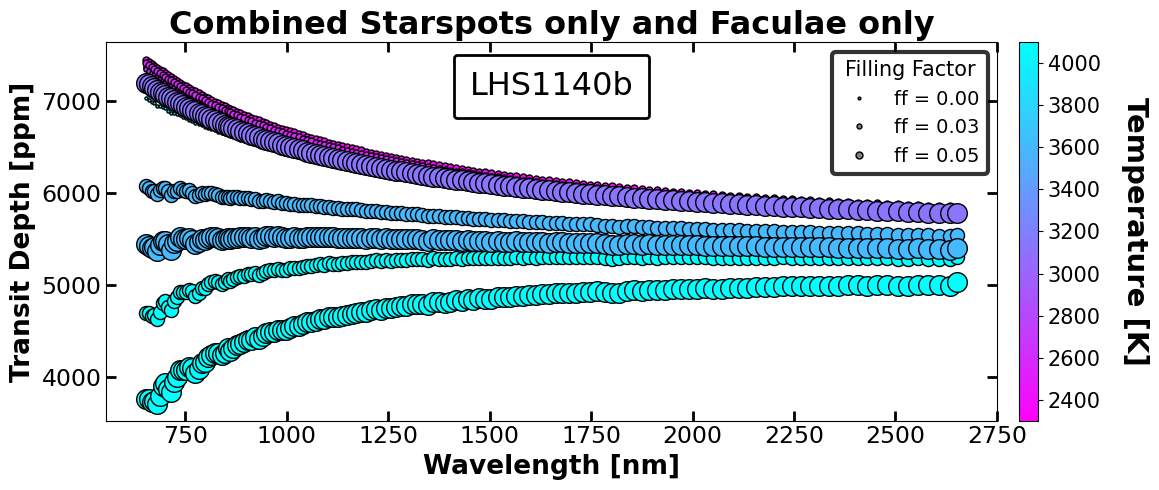

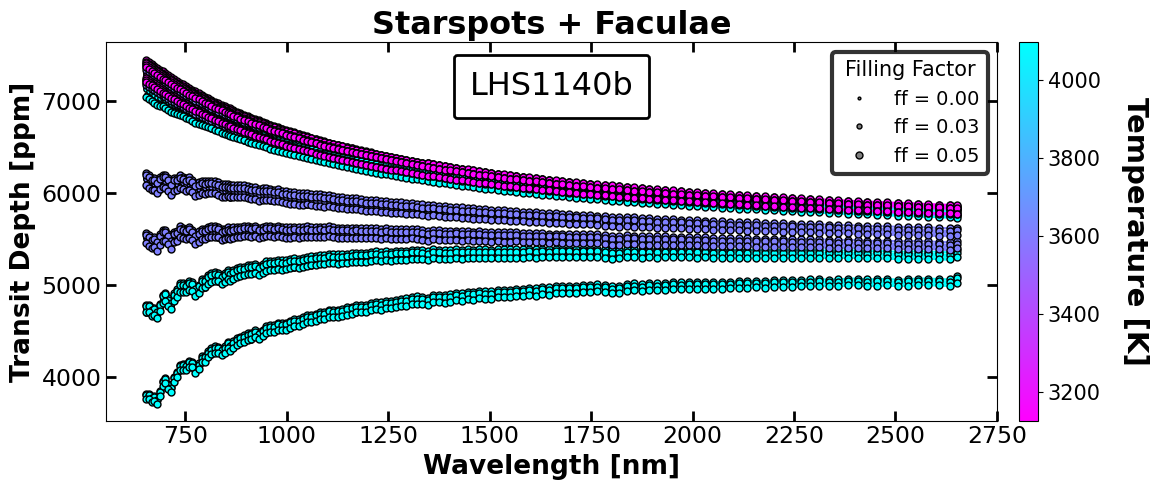

In [2]:
# -*- coding: utf-8 -*-
"""
Part 2 — Plots from raw simulation results

- Reads 'simulation_results_<target>.txt' and plots:
  (A) combined Starspots-only + Faculae-only (color = temperature)
  (B) Spots + Faculae (color = T_facula), marker size = f_spot
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import os
import matplotlib
from matplotlib.offsetbox import AnchoredText
from matplotlib.lines import Line2D
import pandas as pd  # <<<<<<<<<<<<< ADICIONADO

# ------------- Config -------------
target = "LHS1140b"
both_mode = True
file_path = f"simulation_results_{target}.txt"
EPS = 1e-12

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# --- Load simulation data (robusto) ---
# Troca genfromtxt -> pandas.read_csv para lidar com BOM, comentários, espaços, etc.
df = pd.read_csv(
    file_path,
    comment="#",          # ignora metadados com '#'
    encoding="utf-8-sig", # ignora BOM se houver
    skip_blank_lines=True
)

# garante que as colunas existem
need = {"f_spot","tempSpot","f_facula","tempFacula","wavelength","D_lambda"}
missing = need - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns: {sorted(missing)}")

# converte para numpy (float), preservando NaNs
def col(name):
    return pd.to_numeric(df[name], errors="coerce").to_numpy(dtype=float)

f_spot = col("f_spot")
f_fac  = col("f_facula")
T_spot = col("tempSpot")
T_fac  = col("tempFacula")
lam_nm = col("wavelength")
D_ppm  = col("D_lambda")

# masks consistentes
is_spot_only = (np.nan_to_num(f_spot) > EPS) & ((np.nan_to_num(f_fac) <= EPS) | (~np.isfinite(T_fac)))
is_fac_only  = (np.nan_to_num(f_fac)  > EPS) & ((np.nan_to_num(f_spot) <= EPS) | (~np.isfinite(T_spot)))
is_both      = (np.nan_to_num(f_spot) > EPS) & (np.nan_to_num(f_fac) > EPS) & np.isfinite(T_spot) & np.isfinite(T_fac)

print("rows:", len(df),
      "| spot-only:", int(np.sum(is_spot_only)),
      "| fac-only:",  int(np.sum(is_fac_only)),
      "| both:",      int(np.sum(is_both)))

def safe_min_med_max(arr):
    arr = np.asarray(arr, float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0: return (0.05, 0.10, 0.20)
    vmin, vmax = float(np.nanmin(arr)), float(np.nanmax(arr))
    return (vmin, 0.5*(vmin+vmax), vmax)

marker_scale = 500.0
ff_spot_min, ff_spot_med, ff_spot_max = safe_min_med_max(f_spot)
legend_handles = [
    Line2D([0],[0], marker='o', color='w', label=f'ff = {f:.2f}',
           markerfacecolor='gray', markeredgecolor='black',
           markersize=max(2.0, np.sqrt(max(1e-9, marker_scale*f))), linewidth=0)
    for f in [ff_spot_min, ff_spot_med, ff_spot_max]
]

figures = {}

# ===================== BOTH MODE =====================
if both_mode:
    # ---------- FIGURE A: combined Spots-only + Faculae-only ----------
    n_a = int(np.sum(is_spot_only)) + int(np.sum(is_fac_only))
    if n_a > 0:
        # filtra no DataFrame para simplificar o agrupamento
        combined_df = pd.concat([df[is_spot_only], df[is_fac_only]], ignore_index=True) \
            if (int(np.sum(is_spot_only)) and int(np.sum(is_fac_only))) \
            else (df[is_spot_only] if int(np.sum(is_spot_only)) else df[is_fac_only])

        groups = {}
        for _, row in combined_df.iterrows():
            if (row['f_spot'] > EPS) and ((row['f_facula'] <= EPS) or (not np.isfinite(row['tempFacula']))):
                fill, temp = float(row['f_spot']), float(row['tempSpot'])
            elif (row['f_facula'] > EPS) and ((row['f_spot'] <= EPS) or (not np.isfinite(row['tempSpot']))):
                fill, temp = float(row['f_facula']), float(row['tempFacula'])
            else:
                continue
            key = (fill, temp)
            groups.setdefault(key, {'wavelength': [], 'D': []})
            groups[key]['wavelength'].append(float(row['wavelength']))
            groups[key]['D'].append(float(row['D_lambda']))

        temps = np.array([k[1] for k in groups if np.isfinite(k[1])], float)
        if temps.size:
            t_min, t_max = float(np.nanmin(temps)), float(np.nanmax(temps))
            cmap_t = matplotlib.colormaps["cool_r"]; norm_t = Normalize(vmin=t_min, vmax=t_max)
            figA, axA = plt.subplots(figsize=(12, 5))
            for (fill, temp), vals in groups.items():
                if not np.isfinite(temp): continue
                lam = np.array(vals['wavelength']); D = np.array(vals['D'])
                m = np.isfinite(lam) & np.isfinite(D); lam, D = lam[m], D[m]
                if lam.size < 2: continue
                idx = np.argsort(lam)
                axA.scatter(lam[idx], D[idx], s=marker_scale*max(0.0,fill),
                            color=cmap_t(norm_t(temp)), edgecolors='black', linewidths=1, zorder=100)
                axA.plot(lam[idx], D[idx], color=cmap_t(norm_t(temp)))

            axA.set_xlabel("Wavelength [nm]", fontsize=19, fontweight='bold')
            axA.set_ylabel("Transit Depth [ppm]", fontsize=19, fontweight='bold')
            axA.set_title("Combined Starspots only and Faculae only", fontsize=23, fontweight='bold')
            axA.tick_params(axis="x", direction="in", labelsize=17, width=2, length=7, pad=3, top=True)
            axA.tick_params(axis="y", direction="in", labelsize=17, width=2, length=7, pad=3, right=True)
            legend = axA.legend(handles=legend_handles, title='Filling Factor', loc='upper right', fontsize=14, title_fontsize=15)
            legend.get_frame().set_linewidth(3); legend.get_frame().set_edgecolor('black'); legend.get_frame().set_facecolor('white')
            at = AnchoredText(target, loc='upper center', prop=dict(size=23, color='black'), frameon=True)
            at.patch.set_facecolor('white'); at.patch.set_edgecolor('black'); at.patch.set_linewidth(2); at.patch.set_boxstyle("round,pad=0.1")
            axA.add_artist(at)
            smA = ScalarMappable(cmap=cmap_t, norm=norm_t); smA.set_array([])
            cbarA = figA.colorbar(smA, ax=axA, orientation='vertical', pad=0.02)
            cbarA.set_label("Temperature [K]", fontsize=21, fontweight='bold', labelpad=15)
            cbarA.ax.tick_params(labelsize=15); cbarA.ax.yaxis.label.set_rotation(270); cbarA.ax.yaxis.label.set_verticalalignment('bottom')
            figA.tight_layout(); figures["Combined"] = figA
        else:
            print("No valid temperature data for Spots Only + Faculae Only. Skipping combined plot.")
    else:
        print("No rows for Spots Only + Faculae Only. Skipping combined plot.")

    # ---------- FIGURE B: Spots + Faculae ----------
    figB, axB = plt.subplots(figsize=(12, 5))
    df_both = df[is_both]
    if df_both.shape[0] == 0:
        axB.text(0.5, 0.5, "No Spots+Faculae Data Available", ha='center', va='center', fontsize=20)
    else:
        groups_both = {}
        for _, row in df_both.iterrows():
            key = (float(row['f_spot']), float(row['tempSpot']), float(row['f_facula']), float(row['tempFacula']))
            groups_both.setdefault(key, {'wavelength': [], 'D': []})
            groups_both[key]['wavelength'].append(float(row['wavelength']))
            groups_both[key]['D'].append(float(row['D_lambda']))

        tvals = np.array([k[3] for k in groups_both if np.isfinite(k[3])], float)
        if tvals.size:
            cmap_b = matplotlib.colormaps["cool_r"]; norm_b = Normalize(vmin=float(np.nanmin(tvals)), vmax=float(np.nanmax(tvals)))
            for (f_s, t_s, f_f, t_f), vals in groups_both.items():
                if not np.isfinite(t_f): continue
                lam = np.array(vals['wavelength']); D = np.array(vals['D'])
                m = np.isfinite(lam) & np.isfinite(D); lam, D = lam[m], D[m]
                if lam.size < 2: continue
                idx = np.argsort(lam)
                axB.scatter(lam[idx], D[idx], s=marker_scale*max(0.0,f_s),
                            color=cmap_b(norm_b(t_f)), edgecolors='black', linewidths=1, zorder=100)
                axB.plot(lam[idx], D[idx], color=cmap_b(norm_b(t_f)))

            smB = ScalarMappable(cmap=cmap_b, norm=norm_b); smB.set_array([])
            cbarB = figB.colorbar(smB, ax=axB, orientation='vertical', pad=0.02)
            cbarB.set_label("Temperature [K]", fontsize=21, fontweight='bold', labelpad=15)
            cbarB.ax.tick_params(labelsize=15)
            cbarB.ax.yaxis.label.set_rotation(270)
            cbarB.ax.yaxis.label.set_verticalalignment('bottom')

    axB.set_title("Starspots + Faculae", fontsize=23, fontweight='bold')
    axB.set_xlabel("Wavelength [nm]", fontsize=19, fontweight='bold')
    axB.set_ylabel("Transit Depth [ppm]", fontsize=19, fontweight='bold')
    axB.tick_params(axis="x", direction="in", labelsize=17, width=2, length=7, pad=3, top=True)
    axB.tick_params(axis="y", direction="in", labelsize=17, width=2, length=7, pad=3, right=True)
    at = AnchoredText(target, loc='upper center', prop=dict(size=23, color='black'), frameon=True)
    at.patch.set_facecolor('white'); at.patch.set_edgecolor('black'); at.patch.set_linewidth(2); at.patch.set_boxstyle("round,pad=0.1")
    axB.add_artist(at)
    legend = plt.legend(handles=legend_handles, title='Filling Factor', loc='upper right', fontsize=14, title_fontsize=15)
    legend.get_frame().set_linewidth(3); legend.get_frame().set_edgecolor('black'); legend.get_frame().set_facecolor('white')

    plt.tight_layout()
    plt.show()

In [3]:
from __future__ import annotations
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
import os

# -------- config I/O --------
target = "LHS1140b"
both_mode = True
file_path = f"simulation_results_{target}.txt"
EPS = 1e-12

# -------- resolução da malha de interpolação --------
num_ff_spot_interpolations = 10
num_T_spot_interpolations  = 10
num_ff_fac_interpolations  = 10
num_T_fac_interpolations   = 10


# -------- loader robusto --------
def load_simulation_data(path: str):
    """
    Lê o arquivo de simulações e retorna vetores numpy:
    f_spot, T_spot, f_fac, T_fac, wavelength, D_lambda
    Ignora linhas comentadas com '#'.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    cols = ["f_spot", "tempSpot", "f_facula", "tempFacula", "wavelength", "D_lambda"]

    # primeiro tenta ler assumindo que o arquivo já tem cabeçalho com esses nomes
    df = pd.read_csv(
        path,
        comment="#",
        skipinitialspace=True,
    )

    # se as colunas não baterem, relê assumindo que não há cabeçalho
    if not set(cols).issubset(df.columns):
        df = pd.read_csv(
            path,
            comment="#",
            skipinitialspace=True,
            header=None,
            names=cols,
        )

    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {path}: {missing}")

    # garante float (coerce vira NaN se algo estranho)
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return (
        df["f_spot"].to_numpy(float),
        df["tempSpot"].to_numpy(float),
        df["f_facula"].to_numpy(float),
        df["tempFacula"].to_numpy(float),
        df["wavelength"].to_numpy(float),
        df["D_lambda"].to_numpy(float),
    )


# -------- SPOT-only (ff_fac≈0 ou tempFac NaN) --------
def interpolate_results_spot(path: str) -> pd.DataFrame:
    f_spot, T_spot, f_fac, T_fac, wl, D = load_simulation_data(path)

    mask = (f_spot > EPS) & ((f_fac <= EPS) | (~np.isfinite(T_fac)))
    if not np.any(mask):
        return pd.DataFrame(columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])

    f_spot = f_spot[mask]
    T_spot = T_spot[mask]
    wl     = wl[mask]
    D      = D[mask]

    # domínio global de interpolação a partir dos dados
    fmin, fmax = np.nanmin(f_spot), np.nanmax(f_spot)
    Tmin, Tmax = np.nanmin(T_spot), np.nanmax(T_spot)

    ff_spot_interp = np.linspace(fmin, fmax, num_ff_spot_interpolations)
    T_spot_interp  = np.linspace(Tmin, Tmax, num_T_spot_interpolations)

    results = []

    for w in np.unique(wl):
        sel = (wl == w)
        dfw = (
            pd.DataFrame({"f_spot": f_spot[sel], "T_spot": T_spot[sel], "D": D[sel]})
            .groupby(["f_spot", "T_spot"], as_index=False)
            .mean()
        )

        uf = np.sort(dfw["f_spot"].unique())
        uT = np.sort(dfw["T_spot"].unique())

        grid = np.full((len(uf), len(uT)), np.nan)
        for _, r in dfw.iterrows():
            i = np.searchsorted(uf, r["f_spot"])
            j = np.searchsorted(uT, r["T_spot"])
            grid[i, j] = r["D"]

        if np.isnan(grid).any():
            print(f"[!] Warning (spot): λ={w:.3f} skipped due to holes.")
            continue

        rgi = RegularGridInterpolator(
            (uf, uT),
            grid,
            method="linear",
            bounds_error=False,
            fill_value=np.nan,
        )

        FF, TT = np.meshgrid(ff_spot_interp, T_spot_interp, indexing="ij")
        q = np.column_stack((FF.ravel(), TT.ravel()))
        vals = rgi(q)

        # em princípio não deve ter NaN aqui; filtramos por segurança
        good = np.isfinite(vals)
        for (ff, tt), dd in zip(q[good], vals[good]):
            results.append([ff, tt, np.nan, np.nan, w, dd])

    return pd.DataFrame(results, columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])


# -------- FAC-only --------
def interpolate_results_facula(path: str) -> pd.DataFrame:
    f_spot, T_spot, f_fac, T_fac, wl, D = load_simulation_data(path)

    mask = (f_fac > EPS) & ((f_spot <= EPS) | (~np.isfinite(T_spot)))
    if not np.any(mask):
        return pd.DataFrame(columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])

    f_fac = f_fac[mask]
    T_fac = T_fac[mask]
    wl    = wl[mask]
    D     = D[mask]

    # domínio global da facula a partir dos dados
    fmin, fmax = np.nanmin(f_fac), np.nanmax(f_fac)
    Tmin, Tmax = np.nanmin(T_fac), np.nanmax(T_fac)

    ff_fac_interp = np.linspace(fmin, fmax, num_ff_fac_interpolations)
    T_fac_interp  = np.linspace(Tmin, Tmax, num_T_fac_interpolations)

    results = []

    for w in np.unique(wl):
        sel = (wl == w)
        dfw = (
            pd.DataFrame({"f_fac": f_fac[sel], "T_fac": T_fac[sel], "D": D[sel]})
            .groupby(["f_fac", "T_fac"], as_index=False)
            .mean()
        )

        uf = np.sort(dfw["f_fac"].unique())
        uT = np.sort(dfw["T_fac"].unique())

        grid = np.full((len(uf), len(uT)), np.nan)
        for _, r in dfw.iterrows():
            i = np.searchsorted(uf, r["f_fac"])
            j = np.searchsorted(uT, r["T_fac"])
            grid[i, j] = r["D"]

        if np.isnan(grid).any():
            print(f"[!] Warning (facula): λ={w:.3f} skipped due to holes.")
            continue

        rgi = RegularGridInterpolator(
            (uf, uT),
            grid,
            method="linear",
            bounds_error=False,
            fill_value=np.nan,
        )

        FF, TT = np.meshgrid(ff_fac_interp, T_fac_interp, indexing="ij")
        q = np.column_stack((FF.ravel(), TT.ravel()))
        vals = rgi(q)

        good = np.isfinite(vals)
        for (ff, tt), dd in zip(q[good], vals[good]):
            results.append([np.nan, np.nan, ff, tt, w, dd])

    return pd.DataFrame(results, columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])


# -------- BOTH (4D) --------
def interpolate_results_both(path: str) -> pd.DataFrame:
    f_spot, T_spot, f_fac, T_fac, wl, D = load_simulation_data(path)

    mask = (f_spot > EPS) & (f_fac > EPS) & np.isfinite(T_spot) & np.isfinite(T_fac)
    if not np.any(mask):
        return pd.DataFrame(columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])

    f_spot = f_spot[mask]
    T_spot = T_spot[mask]
    f_fac  = f_fac[mask]
    T_fac  = T_fac[mask]
    wl     = wl[mask]
    D      = D[mask]

    # domínio global em 4D a partir dos dados
    fsp_min, fsp_max = np.nanmin(f_spot), np.nanmax(f_spot)
    Tsp_min, Tsp_max = np.nanmin(T_spot), np.nanmax(T_spot)
    ffa_min, ffa_max = np.nanmin(f_fac), np.nanmax(f_fac)
    Tfa_min, Tfa_max = np.nanmin(T_fac), np.nanmax(T_fac)

    ff_spot_interp = np.linspace(fsp_min, fsp_max, num_ff_spot_interpolations)
    T_spot_interp  = np.linspace(Tsp_min, Tsp_max, num_T_spot_interpolations)
    ff_fac_interp  = np.linspace(ffa_min, ffa_max, num_ff_fac_interpolations)
    T_fac_interp   = np.linspace(Tfa_min, Tfa_max, num_T_fac_interpolations)

    results = []

    for w in np.unique(wl):
        sel = (wl == w)
        dfw = (
            pd.DataFrame(
                {
                    "f_spot": f_spot[sel],
                    "T_spot": T_spot[sel],
                    "f_fac":  f_fac[sel],
                    "T_fac":  T_fac[sel],
                    "D":      D[sel],
                }
            )
            .groupby(["f_spot", "T_spot", "f_fac", "T_fac"], as_index=False)
            .mean()
        )

        ufs = np.sort(dfw["f_spot"].unique())
        uTs = np.sort(dfw["T_spot"].unique())
        uff = np.sort(dfw["f_fac"].unique())
        uTf = np.sort(dfw["T_fac"].unique())

        grid = np.full((len(ufs), len(uTs), len(uff), len(uTf)), np.nan)
        for _, r in dfw.iterrows():
            i = np.searchsorted(ufs, r["f_spot"])
            j = np.searchsorted(uTs, r["T_spot"])
            k = np.searchsorted(uff, r["f_fac"])
            l = np.searchsorted(uTf, r["T_fac"])
            grid[i, j, k, l] = r["D"]

        if np.isnan(grid).any():
            print(f"[!] Warning (both): λ={w:.3f} skipped due to holes.")
            continue

        rgi = RegularGridInterpolator(
            (ufs, uTs, uff, uTf),
            grid,
            method="linear",
            bounds_error=False,
            fill_value=np.nan,
        )

        FFs, TTs, FFf, TFf = np.meshgrid(
            ff_spot_interp, T_spot_interp, ff_fac_interp, T_fac_interp, indexing="ij"
        )
        q = np.column_stack((FFs.ravel(), TTs.ravel(), FFf.ravel(), TFf.ravel()))
        vals = rgi(q)

        good = np.isfinite(vals)
        for (ffs, Ts, fff, Tf), dd in zip(q[good], vals[good]):
            results.append([ffs, Ts, fff, Tf, w, dd])

    return pd.DataFrame(results, columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])


# -------- MAIN --------
if __name__ == "__main__":
    df_spot   = interpolate_results_spot(file_path)
    df_facula = interpolate_results_facula(file_path)

    if both_mode:
        df_both = interpolate_results_both(file_path)
        dfs = [df for df in (df_spot, df_facula, df_both) if not df.empty]
        if not dfs:
            raise RuntimeError("No data to save (both_mode=True).")
        df_all = pd.concat(dfs, ignore_index=True)
        out = f"interpolated_results_{target}_both.txt"
    else:
        dfs = [df for df in (df_spot, df_facula) if not df.empty]
        if not dfs:
            raise RuntimeError("No data to save (both_mode=False).")
        df_all = pd.concat(dfs, ignore_index=True)
        out = f"interpolated_results_{target}_combined.txt"

    df_all.to_csv(out, index=False, na_rep="nan")
    print(f"[✓] saved '{out}'")
    print(
        "[info] counts:",
        f"spot={len(df_spot)} facula={len(df_facula)}"
        + (f" both={len(df_both)}" if both_mode else ""),
    )


[✓] saved 'interpolated_results_LHS1140b_both.txt'
[info] counts: spot=14200 facula=14200 both=1420000


rows: 1448400 | spot-only: 14200 | fac-only: 14200 | both: 1420000


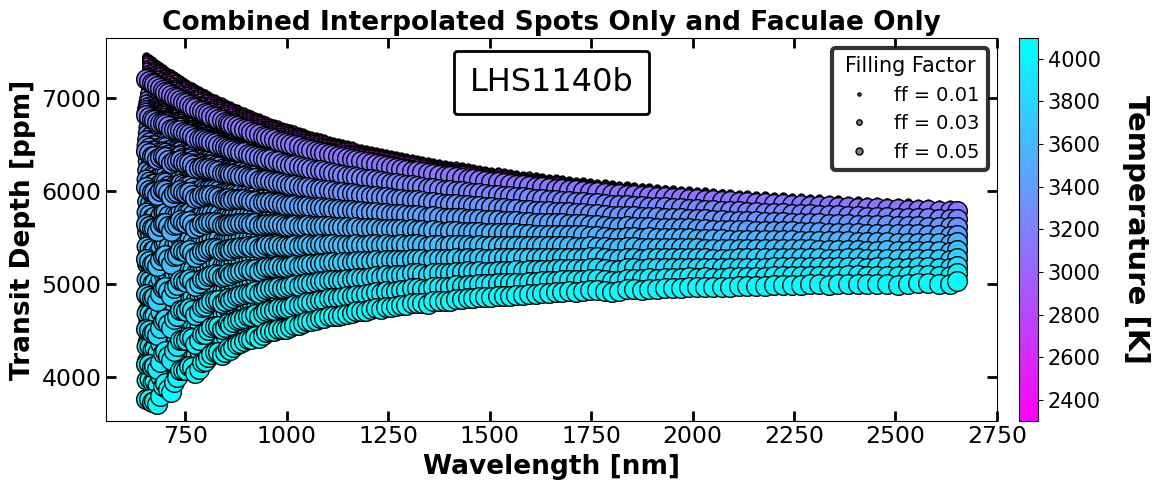

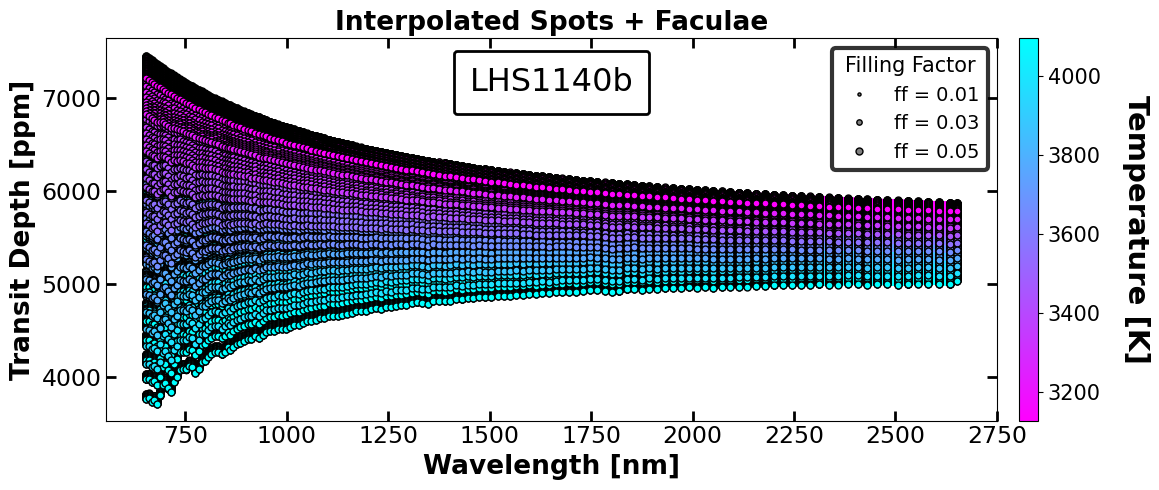

In [4]:
# -*- coding: utf-8 -*-
"""
Part 4 — Plots from interpolated grid

- Reads 'interpolated_results_<target>_(both|combined).txt' and plots:
  (A) combined Spots-only + Faculae-only (interpolated)
  (B) Spots + Faculae (interpolated)
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import os
import matplotlib
from matplotlib.offsetbox import AnchoredText
from matplotlib.lines import Line2D

# ------------- Config -------------
target = "LHS1140b"
both_mode = True
EPS = 1e-12
file_path = f"interpolated_results_{target}_{'both' if both_mode else 'combined'}.txt"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# --- Load interpolated data ---
data = np.genfromtxt(
    file_path,
    delimiter=',',
    names=True,
    dtype=float,
    comments='#',
    autostrip=True,
    encoding='utf-8'
)
cols = set(data.dtype.names or [])

def choose(new_name, old_name):
    if new_name in cols: return new_name
    if old_name in cols: return old_name
    return None

C_T_SPOT = choose('T_spot','tempSpot')
C_T_FAC  = choose('T_facula','tempFacula')
C_F_SPOT = 'f_spot'
C_F_FAC  = 'f_facula'
C_WAVE   = 'wavelength'
C_D      = 'D_lambda'
need = {C_T_SPOT, C_T_FAC, C_F_SPOT, C_F_FAC, C_WAVE, C_D}
if not need.issubset(cols):
    raise KeyError(f"Expected columns not found. Missing: {sorted(need - cols)}")

f_spot = np.asarray(data[C_F_SPOT], float)
f_fac  = np.asarray(data[C_F_FAC], float)
T_spot = np.asarray(data[C_T_SPOT], float)
T_fac  = np.asarray(data[C_T_FAC], float)

is_spot_only = (np.nan_to_num(f_spot) > EPS) & ((np.nan_to_num(f_fac) <= EPS) | (~np.isfinite(T_fac)))
is_fac_only  = (np.nan_to_num(f_fac)  > EPS) & ((np.nan_to_num(f_spot) <= EPS) | (~np.isfinite(T_spot)))
is_both      = (np.nan_to_num(f_spot) > EPS) & (np.nan_to_num(f_fac) > EPS) & np.isfinite(T_spot) & np.isfinite(T_fac)

print("rows:", data.shape[0],
      "| spot-only:", int(np.sum(is_spot_only)),
      "| fac-only:",  int(np.sum(is_fac_only)),
      "| both:",      int(np.sum(is_both)))

def safe_min_med_max(arr):
    arr = np.asarray(arr, float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0: return (0.05, 0.10, 0.20)
    vmin, vmax = float(np.nanmin(arr)), float(np.nanmax(arr))
    return (vmin, 0.5*(vmin+vmax), vmax)

marker_scale = 500.0
ff_spot_min, ff_spot_med, ff_spot_max = safe_min_med_max(f_spot)
legend_handles = [
    Line2D([0],[0], marker='o', color='w', label=f'ff = {f:.2f}',
           markerfacecolor='gray', markeredgecolor='black',
           markersize=max(2.0, np.sqrt(max(1e-9, marker_scale*f))), linewidth=0)
    for f in [ff_spot_min, ff_spot_med, ff_spot_max]
]

# ===================== BOTH MODE =====================
if both_mode:
    # ---------- FIGURE A: combined Spots-only + Faculae-only (interpolated) ----------
    n_a = int(np.sum(is_spot_only)) + int(np.sum(is_fac_only))
    if n_a > 0:
        combined = np.concatenate([data[is_spot_only], data[is_fac_only]]) \
                   if (int(np.sum(is_spot_only)) and int(np.sum(is_fac_only))) \
                   else (data[is_spot_only] if int(np.sum(is_spot_only)) else data[is_fac_only])

        groups = {}
        for row in combined:
            if (row[C_F_SPOT] > EPS) and ((row[C_F_FAC] <= EPS) or (not np.isfinite(row[C_T_FAC]))):
                fill, temp = row[C_F_SPOT], row[C_T_SPOT]
            elif (row[C_F_FAC] > EPS) and ((row[C_F_SPOT] <= EPS) or (not np.isfinite(row[C_T_SPOT]))):
                fill, temp = row[C_F_FAC], row[C_T_FAC]
            else:
                continue
            key = (float(fill), float(temp))
            groups.setdefault(key, {C_WAVE: [], C_D: []})
            groups[key][C_WAVE].append(row[C_WAVE])
            groups[key][C_D].append(row[C_D])

        temps = np.array([k[1] for k in groups if np.isfinite(k[1])], float)
        if temps.size:
            tmin, tmax = float(np.nanmin(temps)), float(np.nanmax(temps))
            cmap = matplotlib.colormaps["cool_r"]; norm = Normalize(vmin=tmin, vmax=tmax)
            figA, axA = plt.subplots(figsize=(12, 5))
            for (fill, temp), vals in groups.items():
                if not np.isfinite(temp): continue
                lam = np.array(vals[C_WAVE]); D = np.array(vals[C_D])
                m = np.isfinite(lam) & np.isfinite(D); lam, D = lam[m], D[m]
                if lam.size < 2: continue
                idx = np.argsort(lam)
                axA.scatter(lam[idx], D[idx], s=marker_scale*max(0.0,fill),
                            color=cmap(norm(temp)), edgecolors='black', linewidths=1, zorder=100)
                axA.plot(lam[idx], D[idx], color=cmap(norm(temp)))

            axA.set_xlabel("Wavelength [nm]", fontsize=19, fontweight='bold')
            axA.set_ylabel("Transit Depth [ppm]", fontsize=19, fontweight='bold')
            axA.set_title("Combined Interpolated Spots Only and Faculae Only", fontsize=19, fontweight='bold')
            axA.tick_params(axis="x", direction="in", labelsize=17, width=2, length=7, pad=3, top=True)
            axA.tick_params(axis="y", direction="in", labelsize=17, width=2, length=7, pad=3, right=True)
            legend = axA.legend(handles=legend_handles, title='Filling Factor', loc='upper right', fontsize=14, title_fontsize=15)
            legend.get_frame().set_linewidth(3); legend.get_frame().set_edgecolor('black'); legend.get_frame().set_facecolor('white')
            at = AnchoredText(target, loc='upper center', prop=dict(size=23, color='black'), frameon=True)
            at.patch.set_facecolor('white'); at.patch.set_edgecolor('black'); at.patch.set_linewidth(2); at.patch.set_boxstyle("round,pad=0.1")
            axA.add_artist(at)
            sm = ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
            cb = figA.colorbar(sm, ax=axA, orientation='vertical', pad=0.02)
            cb.set_label("Temperature [K]", fontsize=21, fontweight='bold', labelpad=15)
            cb.ax.tick_params(labelsize=15); cb.ax.yaxis.label.set_rotation(270); cb.ax.yaxis.label.set_verticalalignment('bottom')
            figA.tight_layout()
        else:
            print("No valid temperature values to color combined plot.")
    else:
        print("No spot-only/facula-only rows in interpolated file. Skipping combined plot.")

    # ---------- FIGURE B: Spots + Faculae (interpolated) ----------
    figB, axB = plt.subplots(figsize=(12, 5))
    mask_both = is_both
    if data[mask_both].size == 0:
        axB.text(0.5, 0.5, "No Interpolated Spots+Faculae Data Available", ha='center', va='center', fontsize=20)
    else:
        groups_both = {}
        for row in data[mask_both]:
            key = (row[C_F_SPOT], row[C_T_SPOT], row[C_F_FAC], row[C_T_FAC])
            groups_both.setdefault(key, {C_WAVE: [], C_D: []})
            groups_both[key][C_WAVE].append(row[C_WAVE])
            groups_both[key][C_D].append(row[C_D])

        tvals = np.array([k[3] for k in groups_both if np.isfinite(k[3])], float)  # T_facula for color
        if tvals.size:
            cmap = matplotlib.colormaps["cool_r"]; norm = Normalize(vmin=float(np.nanmin(tvals)), vmax=float(np.nanmax(tvals)))
            for (f_s, t_s, f_f, t_f), vals in groups_both.items():
                if not np.isfinite(t_f): continue
                lam = np.array(vals[C_WAVE]); D = np.array(vals[C_D])
                m = np.isfinite(lam) & np.isfinite(D); lam, D = lam[m], D[m]
                if lam.size < 2: continue
                idx = np.argsort(lam)
                axB.scatter(lam[idx], D[idx], s=marker_scale*max(0.0,f_s),
                            color=cmap(norm(t_f)), edgecolors='black', linewidths=1, zorder=100)
                axB.plot(lam[idx], D[idx], color=cmap(norm(t_f)))

            sm = ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
            cb = figB.colorbar(sm, ax=axB, orientation='vertical', pad=0.02)
            cb.set_label("Temperature [K]", fontsize=21, fontweight='bold', labelpad=15)
            cb.ax.tick_params(labelsize=15); cb.ax.yaxis.label.set_rotation(270); cb.ax.yaxis.label.set_verticalalignment('bottom')

    axB.set_xlabel("Wavelength [nm]", fontsize=19, fontweight='bold')
    axB.set_ylabel("Transit Depth [ppm]", fontsize=19, fontweight='bold')
    axB.set_title("Interpolated Spots + Faculae", fontsize=19, fontweight='bold')
    axB.tick_params(axis="x", direction="in", labelsize=17, width=2, length=7, pad=3, top=True)
    axB.tick_params(axis="y", direction="in", labelsize=17, width=2, length=7, pad=3, right=True)
    at = AnchoredText(target, loc='upper center', prop=dict(size=23, color='black'), frameon=True)
    at.patch.set_facecolor('white'); at.patch.set_edgecolor('black'); at.patch.set_linewidth(2); at.patch.set_boxstyle("round,pad=0.1")
    axB.add_artist(at)
    legend = axB.legend(handles=legend_handles, title='Filling Factor', loc='upper right', fontsize=14, title_fontsize=15)
    legend.get_frame().set_linewidth(3); legend.get_frame().set_edgecolor('black'); legend.get_frame().set_facecolor('white')

    plt.tight_layout()
    plt.show()